Required Files at Working Directory


1.   main.csv
2.   nasdaq_screener.csv



# Import Libraries

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import json
from sklearn.metrics import mean_absolute_percentage_error

# Set Working Directory

In [2]:
work_dir=r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1"

# Load Data

In [3]:
data = pd.read_csv(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\dataset\main.csv")
cols_to_drop = data.columns[data.columns.str.contains('fiscal_quarter_key')]
data.drop(cols_to_drop, axis=1, inplace=True)
grouped = data.groupby('Symbol')

# Count the number of samples per symbol
lengths = [(symbol, len(group)) for symbol, group in grouped]
lengths_sorted = sorted(lengths, key=lambda x: x[1])

# Count the number of companies with more than or equal to 80 samples
count = sum(1 for symbol, length in lengths_sorted if length >= 80)
print("Number of companies with more than 80 samples:", count)
stockno = count
# Filter subgroups with more than or equal to 80 samples
filtered_groups = [(symbol, group) for symbol, group in grouped if len(group) >=80]

# Define a function to truncate each subgroup to 80 samples
def truncate_to_80(group):
    return group.iloc[:80]

# Apply the truncation function to each subgroup in filtered_groups
truncated_groups = [(symbol, truncate_to_80(group)) for symbol, group in filtered_groups]
filtered_data = pd.concat([group for symbol, group in truncated_groups])
companies = filtered_data['Symbol'].unique()
cols_to_drop = data.columns[data.columns.str.contains('Symbol')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop = data.columns[data.columns.str.contains('period_end_date')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop = data.columns[data.columns.str.contains('fiscal_quarter_number')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
data = filtered_data.to_numpy()
print(len(data[0]))

Number of companies with more than 80 samples: 1658
109


# PreProcessing

In [4]:
def pre_process(data,sequence_length,overlap,batch_size):
  # here 70 samples are grouped together into a sub group : Train and 10 : Test
  grouped_data = []
  grouped_data_test = []
  for i in range(stockno):
      train_start_index = i*80
      train_end_index = (i+1)*80-10

      test_start_index = train_end_index
      test_end_index = test_start_index + 10

      grouped_data.append(data[train_start_index:train_end_index])
      grouped_data_test.append(data[test_start_index:test_end_index])
  grouped_data = np.array(grouped_data) # contains data for each company in subgroup
  len(grouped_data[-1])
  grouped_data[0][0:0+sequence_length]

  # this cell normnalize the dataset by groupwise
  train_mean_ref=[]
  train_std_ref=[]

  test_mean_ref=[]
  test_std_ref=[]

  for i in range(len(grouped_data)):
      mean_vector = np.mean(grouped_data[i], axis=0)
      std_vector = np.std(grouped_data[i], axis=0)

      # Check for zero standard deviation
      zero_std_indices = np.where(std_vector == 0)[0]

      # Avoid division by zero and handle NaN
      std_vector[std_vector == 0] = 1  # Replace zero standard deviations with 1 to avoid division by zero

      # Reference of mean and std
      train_mean_ref.append(mean_vector)
      train_std_ref.append(std_vector)
      # Normalize the data
      normalized_data = (grouped_data[i] - mean_vector) / std_vector

      # Handle elements where standard deviation was zero
      normalized_data[:, zero_std_indices] = 0  # Set corresponding elements to zero

      # Assign the normalized data back to grouped_data
      grouped_data[i] = normalized_data


  for i in range(len(grouped_data_test)):
      mean_vector = np.mean(grouped_data_test[i], axis=0)
      std_vector = np.std(grouped_data_test[i], axis=0)

      # Check for zero standard deviation
      zero_std_indices = np.where(std_vector == 0)[0]

      # Avoid division by zero and handle NaN
      std_vector[std_vector == 0] = 1  # Replace zero standard deviations with 1 to avoid division by zero

      # Reference of mean and std
      test_mean_ref.append(mean_vector)
      test_std_ref.append(std_vector)
      # Normalize the data
      normalized_data = (grouped_data_test[i] - mean_vector) / std_vector

      # Handle elements where standard deviation was zero
      normalized_data[:, zero_std_indices] = 0  # Set corresponding elements to zero

      # Assign the normalized data back to grouped_data
      grouped_data_test[i] = normalized_data



  dataset=[]
  for i in range(len(grouped_data)):#1658
      for j in range(len(grouped_data[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data[i]):
              datapoint = grouped_data[i][j*(sequence_length - overlap):j*(sequence_length - overlap)+sequence_length]
              #print(len(datapoint))
              dataset.append(datapoint)
          else:
              break
  dataset_test=[]
  for i in range(len(grouped_data_test)):#1658
      for j in range(len(grouped_data_test[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data_test[i]):
              datapoint = grouped_data_test[i][j*(sequence_length - overlap):j*(sequence_length - overlap)+sequence_length]
              dataset_test.append(datapoint)
          else:
              break



  dataset = np.array(dataset)
  features = dataset[:, :, :-1]

  dataset_test = np.array(dataset_test)
  features_test = dataset_test[:, :, :-1]
  print(features.shape, features_test.shape)



  targets = []
  for i in range(len(grouped_data)):#1658
      for j in range(len(grouped_data[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data[i]):
              target = grouped_data[i][j*(sequence_length - overlap)+sequence_length][-1]
              targets.append(target)
          else:
              break

  targets_test = []
  for i in range(len(grouped_data_test)):#1658
      for j in range(len(grouped_data_test[i])):#10
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data_test[i]):
              target = grouped_data_test[i][j*(sequence_length - overlap)+sequence_length][-1]

              targets_test.append(target)
          else:
              #print(j)
              break

  targets = np.array(targets)
  print(targets.shape)
  features = torch.tensor(features, dtype=torch.float32)
  targets = torch.tensor(targets, dtype=torch.float32)


  targets_test = np.array(targets_test)
  print(targets_test.shape)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  targets_test = torch.tensor(targets_test, dtype=torch.float32)



  X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataset = TensorDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  test_dataset = TensorDataset(features_test, targets_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader,val_loader,test_loader,test_mean_ref,test_std_ref

# Models

## MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, sequence_length):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=(input_size*sequence_length), out_features=256)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(in_features=64, out_features=32)
        self.dropout4 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(in_features=32, out_features=16)
        self.fc6 = nn.Linear(in_features=16, out_features=output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

## LSTM

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        _, (h_n, _) = self.lstm(x, (h_0, c_0))
        output = self.fc(h_n[-1])
        return output

## LSTM-AT

In [7]:
# Define the model
class LSTMAttentionRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMAttentionRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        output, _ = self.lstm(x, (h_0, c_0))
        attention_weights = nn.functional.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attention_weights * output, dim=1)
        output = self.fc(context_vector)
        return output

## CNN-LSTM-AT

In [8]:
#Model Implementation

class CNN_LSTM_AM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, sequence_length, dropout_porb):
        super(CNN_LSTM_AM, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.conv1d_2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.conv1d_3 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.pool = nn.MaxPool1d(kernel_size=1, padding=0)
        self.lstm_1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, bias = True)
        self.lstm_2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True, bias = True)
        self.attention_linear = nn.Linear(hidden_dim * 2, 1, bias = True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim, bias = True)
        self.sequence_length = sequence_length
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, input_dim = x.size()

        # Reshape for Conv1d input
        x = x.permute(0, 2, 1)  # Reshape for Conv1d input
        x = self.pool(F.relu(self.conv1d_1(x)))
        x = self.pool(F.relu(self.conv1d_2(x)))
        x = self.pool(F.relu(self.conv1d_3(x)))

        x = self.dropout(x)
        # Reshape for LSTM input
        x = x.permute(0, 2, 1)  # Reshape for LSTM input
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = self.dropout(x)
        # Attention mechanism
        attention_weights = F.softmax(self.attention_linear(x), dim=1)
        attended_out = torch.sum(attention_weights * x, dim=1)

        # Output layer
        output = self.linear(attended_out)

        return output

In [9]:
class BiLSTM_AM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, sequence_length, dropout_prob):
        super(BiLSTM_AM, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, bias=True)
        self.lstm_2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True, bias=True)
        self.attention_linear = nn.Linear(hidden_dim * 2, 1, bias=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim, bias=True)
        self.sequence_length = sequence_length
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, input_dim = x.size()

        # LSTM layers
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = self.dropout(x)

        # Attention mechanism
        attention_weights = F.softmax(self.attention_linear(x), dim=1)
        attended_out = torch.sum(attention_weights * x, dim=1)

        # Output layer
        output = self.linear(attended_out)

        return output

# Model Run

In [10]:
def model_run(model,train_loader,test_loader,val_loader,model_details,work_dir):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  train_losses = []
  val_losses = []
  num_epochs = 50
  all_predictions = []
  all_true_values = []

  # Training
  #best_val_loss = float('inf')
  patience = 10  # Number of epochs to wait for improvement
  counter = 0
  for epoch in range(num_epochs):
      model.train()
      running_train_loss = 0.0
      progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False, mininterval=1)
      for inputs, labels in progress_bar:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs.float())
          loss = criterion(outputs.squeeze(), labels.float())

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_train_loss += loss.item()
          progress_bar.set_postfix({'loss': running_train_loss / len(train_loader)})

      # Record training loss for this epoch
      train_losses.append(running_train_loss / len(train_loader))

      # Validation loop
      model.eval()
      running_val_loss = 0.0
      predictions = []
      true_values = []
      with torch.no_grad():
      #    val_progress_bar = tqdm(val_dataloader, desc=f'Validation', leave=False, mininterval=1)
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)#labels are normalized

              # Forward pass
              normalized_outputs = model(inputs.float())
              loss = criterion(normalized_outputs.squeeze(), labels.float()) # losses are computed between normalized outputs and nromalized prediction

              running_val_loss += loss.item()

              #outputs = normalized_outputs * vector_max[-1]
              #labels = labels * vector_max[-1]
              # Store predicted and true values
              predictions.extend(normalized_outputs.cpu().numpy())
              true_values.extend(labels.cpu().numpy())

          # Record validation loss for this epoch
          val_losses.append(running_val_loss / len(val_loader))

      all_predictions.append(predictions)
      all_true_values.append(true_values)
      """
      avg_val_loss = running_val_loss / len(val_dataloader)
      if avg_val_loss < best_val_loss: #check for the improvement of val_loss
          best_val_loss = avg_val_loss
          counter = 0
      else:
          counter = counter + 1
      if counter >= patience:
          print(f'Early stopping after {epoch+1} epochs without improvement.')
          break"""
      # Print average loss for this epoch
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

  # Plot training and validation losses
  plt.figure()
  plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training and Validation Losses for {model_details}')
  plt.legend()
  plt.savefig(f'{work_dir}/model_loss_{model_details}.png')
  plt.show()
  

  #TestingModel
  model.eval()
  running_test_loss = 0.0
  predictions_test_data = []
  true_values_test_data = []
  with torch.no_grad():
  #    val_progress_bar = tqdm(val_dataloader, desc=f'Validation', leave=False, mininterval=1)
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)#labels are normalized

          # Forward pass
          normalized_outputs = model(inputs.float())
          loss = criterion(normalized_outputs.squeeze(), labels.float()) # losses are computed between normalized outputs and nromalized prediction

          running_val_loss += loss.item()

          #outputs = normalized_outputs * vector_max[-1]
          #labels = labels * vector_max[-1]
          # Store predicted and true values
          predictions_test_data.extend(normalized_outputs.cpu().numpy())
          true_values_test_data.extend(labels.cpu().numpy())

      print(f"Test Loss for {model_details}:", running_val_loss / len(test_loader))

  return predictions_test_data,true_values_test_data,train_losses,val_losses

# PostProcessing

In [11]:
def post_processing(test_mean_ref,test_std_ref,predictions_test_data,true_values_test_data,sequence_length,model_details,work_dir, companies,train_losses,val_losses):
  test_mean_ref_target = []
  test_std_ref_target = []

  for i in range(len(test_mean_ref)):
    test_mean_ref_target.append(test_mean_ref[i][-1])
    test_std_ref_target.append(test_std_ref[i][-1])

  test_by_comp_pred=[]
  test_by_comp_act=[]
  test_by_comp_pred = [x[0] for x in predictions_test_data]

  test_by_comp_pred = [test_by_comp_pred[i * (10-sequence_length) : (i + 1) * (10-sequence_length)] for i in range(stockno)]
  test_by_comp_act = [true_values_test_data[i * (10-sequence_length) : (i + 1) * (10-sequence_length)] for i in range(stockno)]

  for i in range(len(test_by_comp_pred)):
    test_by_comp_pred[i] = [x * test_std_ref_target[i] + test_mean_ref_target[i] for x in test_by_comp_pred[i]]
    test_by_comp_act[i] = [x * test_std_ref_target[i] + test_mean_ref_target[i] for x in test_by_comp_act[i]]


  pct_value_error = {}
  maerr = {}
  for i in range(len(test_by_comp_act)):
    pred_tmp = test_by_comp_pred[i]
    act_tmp = test_by_comp_act[i]
    from sklearn.metrics import mean_absolute_percentage_error
    pct_value_error[companies[i]] = mean_absolute_percentage_error(act_tmp,pred_tmp)
    maerr[companies[i]] = mean_absolute_error(act_tmp,pred_tmp)


  with open(f'{work_dir}/mae_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(maerr))

  with open(f'{work_dir}/pct_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(pct_value_error))

  train_losses = {model_details: train_losses}
  with open(f'{work_dir}/train_loss_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(train_losses))
      
  val_losses = {model_details: val_losses}
  with open(f'{work_dir}/val_loss_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(val_losses))
      
  predictions={}
  actual={}

  for i in range(len(test_by_comp_pred)):
    predictions[companies[i]]=test_by_comp_pred[i]
    actual[companies[i]]=test_by_comp_act[i]

  with open(f'{work_dir}/pred_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(predictions))

  with open(f'{work_dir}/act_{model_details}.json', 'w') as convert_file:
      convert_file.write(json.dumps(actual))

# Experiment Setup

cuda
Model: MLP
(109428, 4, 108) (9948, 4, 108)
(109428,)
(9948,)


Epoch 1/50, Train Loss: 0.272466633434826, Val Loss: 0.20414804005527606


Epoch 2/50, Train Loss: 0.20043014431173362, Val Loss: 0.19667232330446238


Epoch 3/50, Train Loss: 0.18822944976138362, Val Loss: 0.1915963786105587


Epoch 4/50, Train Loss: 0.18080710429381228, Val Loss: 0.19129812967491477


Epoch 5/50, Train Loss: 0.1741699259010155, Val Loss: 0.18879146796978635


Epoch 6/50, Train Loss: 0.1678062318794978, Val Loss: 0.1992068282970691


Epoch 7/50, Train Loss: 0.16153303196846264, Val Loss: 0.18936237416838267


Epoch 8/50, Train Loss: 0.15609753011980615, Val Loss: 0.18946339919754904


Epoch 9/50, Train Loss: 0.15181620361901466, Val Loss: 0.19332933761859866


Epoch 10/50, Train Loss: 0.14629045856328332, Val Loss: 0.19130946437670895


Epoch 11/50, Train Loss: 0.14225023871671721, Val Loss: 0.1915924844404334


Epoch 12/50, Train Loss: 0.1372927618306077, Val Loss: 0.1946274521314118


Epoch 13/50, Train Loss: 0.13302574987267424, Val Loss: 0.19046475546068797


Epoch 25/50, Train Loss: 0.0981410960525887, Val Loss: 0.19673345557766964


Epoch 26/50:  12%|█▏        | 434/3502 [00:01<00:07, 433.57it/s, loss=0.0164]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 26/50, Train Loss: 0.09717468838704732, Val Loss: 0.19575122637954884


Epoch 27/50, Train Loss: 0.09505652659000889, Val Loss: 0.1959933648226128


Epoch 28/50, Train Loss: 0.09374628885133753, Val Loss: 0.19556188129194796


Epoch 40/50, Train Loss: 0.07974330663227869, Val Loss: 0.19972187738661487


Epoch 41/50:  51%|█████     | 1781/3502 [00:04<00:03, 444.21it/s, loss=0.0431]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 49/50, Train Loss: 0.07265976093590328, Val Loss: 0.1972590873451674


Epoch 50/50, Train Loss: 0.07265530110388432, Val Loss: 0.2003072848815692


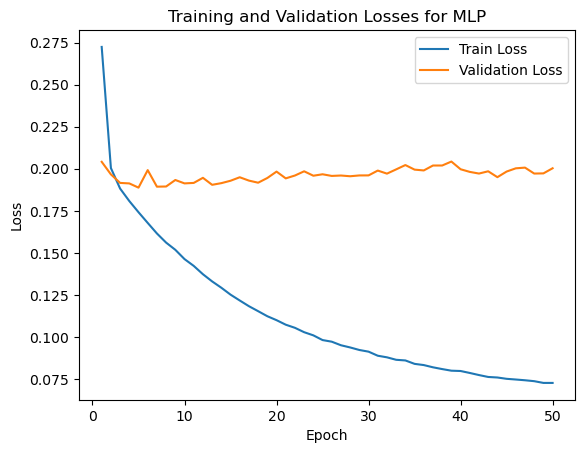

Test Loss for MLP: 1.2793526739050545
Model: LSTM
(109428, 4, 108) (9948, 4, 108)
(109428,)
(9948,)


Epoch 1/50, Train Loss: 0.23482247091710637, Val Loss: 0.19763670955065926


Epoch 2/50, Train Loss: 0.18208671405673163, Val Loss: 0.1873474034765676


Epoch 3/50, Train Loss: 0.17177214523801831, Val Loss: 0.1837180493629142


Epoch 4/50, Train Loss: 0.16438068523215846, Val Loss: 0.18115605304621535


Epoch 5/50, Train Loss: 0.15753415060510964, Val Loss: 0.1793975138028905


Epoch 6/50, Train Loss: 0.15096955222563274, Val Loss: 0.1780468629413714


Epoch 7/50, Train Loss: 0.14401955835559516, Val Loss: 0.1757829866635711


Epoch 8/50, Train Loss: 0.13723527014400194, Val Loss: 0.17599396280025784


Epoch 32/50, Train Loss: 0.03094635059488464, Val Loss: 0.17462179012656143


Epoch 33/50:  61%|██████    | 2124/3502 [00:05<00:03, 425.85it/s, loss=0.0171] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 34/50, Train Loss: 0.02734946939314496, Val Loss: 0.17469596500470214


Epoch 35/50, Train Loss: 0.025741245035935237, Val Loss: 0.17614597469976503


Epoch 36/50, Train Loss: 0.024214063235731432, Val Loss: 0.17783186527726041


Epoch 47/50, Train Loss: 0.012713943591151494, Val Loss: 0.18216330947175827


Epoch 48/50, Train Loss: 0.012064744458482763, Val Loss: 0.18204681606767656


Epoch 49/50, Train Loss: 0.011428101251017769, Val Loss: 0.18148518171263475


Epoch 10/50:  86%|████████▋ | 3026/3502 [00:08<00:01, 381.12it/s, loss=0.118] ]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 11/50, Train Loss: 0.11896449151841965, Val Loss: 0.17357780633825962


Epoch 12/50, Train Loss: 0.1126201483873126, Val Loss: 0.17395951130244558


Epoch 13/50, Train Loss: 0.10596878769015547, Val Loss: 0.17297323873972512


Epoch 23/50, Train Loss: 0.05719039140791467, Val Loss: 0.17098256411056403


Epoch 24/50:  32%|███▏      | 1129/3502 [00:03<00:06, 370.25it/s, loss=0.0198]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 25/50, Train Loss: 0.05044813044656436, Val Loss: 0.17198196830457613


Epoch 26/50, Train Loss: 0.04747256443706548, Val Loss: 0.17306113445314847


Epoch 37/50:  85%|████████▌ | 2979/3502 [00:08<00:01, 369.79it/s, loss=0.0218] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 40/50, Train Loss: 0.020634523443896314, Val Loss: 0.17915883125762824


Epoch 41/50, Train Loss: 0.01959345391329201, Val Loss: 0.17912885517553856


Epoch 1/50, Train Loss: 0.2303352996585694, Val Loss: 0.19768443952429376


Epoch 2/50:  35%|███▍      | 1214/3502 [00:05<00:09, 240.68it/s, loss=0.0755]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 4/50, Train Loss: 0.16899064561880822, Val Loss: 0.1832138576149328


Epoch 5/50, Train Loss: 0.16193258778741534, Val Loss: 0.17884322208645817


Epoch 12/50, Train Loss: 0.118444096575731, Val Loss: 0.16417047447741848


Epoch 13/50:  27%|██▋       | 955/3502 [00:04<00:10, 238.92it/s, loss=0.0356] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 13/50, Train Loss: 0.11336418945418893, Val Loss: 0.1701049827545303


Epoch 14/50, Train Loss: 0.10857111385367653, Val Loss: 0.16115380743025168


Epoch 21/50:  90%|████████▉ | 3139/3502 [00:14<00:01, 235.12it/s, loss=0.082] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 22/50, Train Loss: 0.08415942479495166, Val Loss: 0.15214114301927287


Epoch 23/50, Train Loss: 0.08148666782712065, Val Loss: 0.14994822870982497


Epoch 30/50, Train Loss: 0.06973982268124224, Val Loss: 0.1461922797399943


Epoch 31/50:   0%|          | 0/3502 [00:00<?, ?it/s, loss=0.0016]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 31/50, Train Loss: 0.06828598223407478, Val Loss: 0.14546911919821207


Epoch 32/50, Train Loss: 0.06642800559162634, Val Loss: 0.14528672079253754


Epoch 39/50, Train Loss: 0.0586512111356617, Val Loss: 0.14201379644994935


Epoch 40/50:  35%|███▍      | 1215/3502 [00:05<00:09, 235.87it/s, loss=0.0214]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 41/50, Train Loss: 0.05652585987912237, Val Loss: 0.13678905992772958


Epoch 42/50, Train Loss: 0.05585277343045458, Val Loss: 0.13703621259877738


Epoch 47/50, Train Loss: 0.05154625388359101, Val Loss: 0.13591603410842756


Epoch 48/50:  14%|█▎        | 475/3502 [00:02<00:12, 236.29it/s, loss=0.00744]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/50, Train Loss: 0.2164545049045186, Val Loss: 0.19499834440648556


Epoch 2/50, Train Loss: 0.17997264617395564, Val Loss: 0.1854367780214235


Epoch 10/50, Train Loss: 0.11044002543743392, Val Loss: 0.1705197889238732


Epoch 11/50:  16%|█▌        | 548/3502 [00:02<00:10, 271.46it/s, loss=0.0223] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 14/50, Train Loss: 0.08301597805124633, Val Loss: 0.166453594652315


Epoch 15/50, Train Loss: 0.07692231731632908, Val Loss: 0.16574945689931717


Epoch 23/50, Train Loss: 0.04167289723020402, Val Loss: 0.15546229245251716


Epoch 24/50:  61%|██████    | 2119/3502 [00:08<00:05, 260.80it/s, loss=0.0238]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 28/50, Train Loss: 0.028208593963174683, Val Loss: 0.15180221541899525


Epoch 29/50, Train Loss: 0.026181866452209587, Val Loss: 0.15323485956914282


Epoch 37/50, Train Loss: 0.014766525184370785, Val Loss: 0.14608051002952674


Epoch 38/50:  24%|██▍       | 832/3502 [00:03<00:09, 275.97it/s, loss=0.00337] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 42/50, Train Loss: 0.010861445387130202, Val Loss: 0.14395465090930393


Epoch 43/50, Train Loss: 0.010378542278472043, Val Loss: 0.1450538195108306


Epoch 44/50:  78%|███████▊  | 2721/3502 [00:10<00:02, 271.69it/s, loss=0.00756]

In [ ]:
sequence_length = 4
overlap = 3
batch_size = 25
input_dim = len(data[0]) - 1
hidden_dim = 256
output_dim = 1
dropout_prob = 0.2


#initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

MLP_model = MLP(input_dim, output_dim, sequence_length).to(device)
LSTM_model = LSTM(input_dim, hidden_dim, output_dim).to(device)
LSTM_AT_model = LSTMAttentionRegressor(input_dim, hidden_dim, output_dim).to(device)
CNN_LSTM_AM_model = CNN_LSTM_AM(input_dim, hidden_dim, output_dim, sequence_length, dropout_prob).to(device)
Bi_LSTM_model = BiLSTM_AM(input_dim, hidden_dim, output_dim, sequence_length, dropout_prob).to(device)
models={'MLP':MLP_model,
        'LSTM':LSTM_model,
        'LSTM_AT':LSTM_AT_model,
        'CNN_LSTM_AM':CNN_LSTM_AM_model,
        'Bi_LSTM':Bi_LSTM_model}

# Model implementation
for model_name,model in models.items():
  print("Model:",model_name)
  train_loader,val_loader,test_loader,test_mean_ref,test_std_ref = pre_process(data,sequence_length,overlap,batch_size)
  predictions_test_data,true_values_test_data,train_losses,val_losses = model_run(model,train_loader,test_loader,val_loader,model_name,work_dir)
  post_processing(test_mean_ref,test_std_ref,predictions_test_data,true_values_test_data,sequence_length,model_name,work_dir, companies,train_losses,val_losses)

In [27]:
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\train_loss_MLP.json", 'r') as f1:
    data1 = json.load(f1)

# Load the second JSON file
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\train_loss_LSTM.json", 'r') as f2:
    data2 = json.load(f2)

with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\train_loss_LSTM_AT.json", 'r') as f3:
    data3 = json.load(f3)

with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\train_loss_CNN_LSTM_AM.json", 'r') as f4:
    data4 = json.load(f4)
    
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\train_loss_Bi_LSTM.json", 'r') as f5:
    data5 = json.load(f5)
print("data1", data1)
print("data2", data2)

data1 {'MLP': [0.272466633434826, 0.20043014431173362, 0.18822944976138362, 0.18080710429381228, 0.1741699259010155, 0.1678062318794978, 0.16153303196846264, 0.15609753011980615, 0.15181620361901466, 0.14629045856328332, 0.14225023871671721, 0.1372927618306077, 0.13302574987267424, 0.12926186555661454, 0.1251586716800826, 0.12167931243198589, 0.11827554480826374, 0.11531916623355354, 0.11231762215097263, 0.1099705916394861, 0.10728095713492243, 0.10542180752706129, 0.10281683155295594, 0.10094190183771654, 0.0981410960525887, 0.09717468838704732, 0.09505652659000889, 0.09374628885133753, 0.09224060445764383, 0.09124455759317739, 0.08882821314590002, 0.08787708824286626, 0.0864079454302073, 0.08602454927114335, 0.08398820510318132, 0.08327228906827695, 0.0819420460170121, 0.08088808392426121, 0.07992925060150251, 0.07974330663227869, 0.07857673952588945, 0.07733129755807121, 0.0761977697481672, 0.07588296964166762, 0.075097281494572, 0.0746819764952245, 0.07423718518304662, 0.0736934198

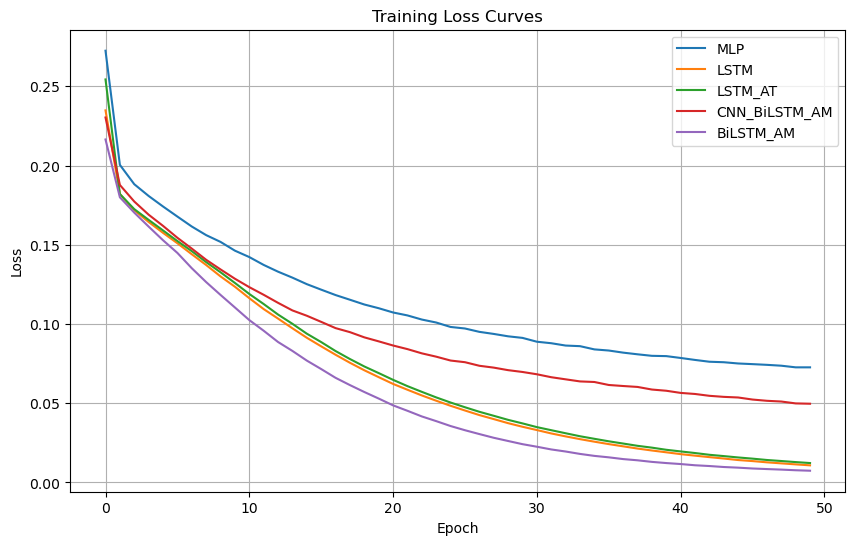

In [28]:
# Plot the curves
plt.figure(figsize=(10, 6))

# Plot data1
plt.plot(data1['MLP'], label='MLP')

# Plot data2
plt.plot(data2['LSTM'], label='LSTM')

# Plot data3
plt.plot(data3['LSTM_AT'], label='LSTM_AT')

# Plot data4
plt.plot(data4['CNN_LSTM_AM'], label='CNN_BiLSTM_AM')

plt.plot(data5['Bi_LSTM'], label='BiLSTM_AM')

plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig(f'{work_dir}/train_loss_all.png')

# Show the plot
plt.show()

In [21]:
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\val_loss_MLP.json", 'r') as f1:
    data1 = json.load(f1)

# Load the second JSON file
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\val_loss_LSTM.json", 'r') as f2:
    data2 = json.load(f2)

with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\val_loss_LSTM_AT.json", 'r') as f3:
    data3 = json.load(f3)

with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\val_loss_CNN_LSTM_AM.json", 'r') as f4:
    data4 = json.load(f4)

with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\val_loss_Bi_LSTM.json", 'r') as f5:
    data5 = json.load(f5)

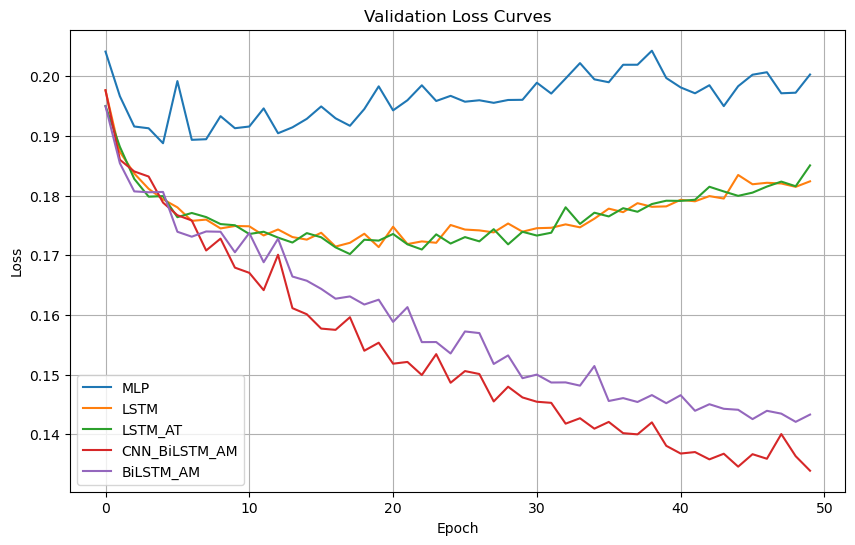

In [25]:
plt.figure(figsize=(10, 6))

# Plot data1
plt.plot(data1['MLP'], label='MLP')

# Plot data2
plt.plot(data2['LSTM'], label='LSTM')

# Plot data3
plt.plot(data3['LSTM_AT'], label='LSTM_AT')

# Plot data4
plt.plot(data4['CNN_LSTM_AM'], label='CNN_BiLSTM_AM')

plt.plot(data5['Bi_LSTM'], label='BiLSTM_AM')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig(f'{work_dir}/val_loss_all.png')

# Show the plot
plt.show()

In [23]:
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\act_CNN_LSTM_AM.json", 'r') as f1:
    actual_values = json.load(f1)
with open(r"C:\Users\17436\OneDrive\desktop\ECSE 552\Project\final_results1\pred_CNN_LSTM_AM.json", 'r') as f2:
    predictions = json.load(f2)

print(len(actual_values))
key = 'A'  # Replace 'A' with the key you want to check
num_elements = len(actual_values[key])
print("Number of elements in key", key, ":", num_elements)

1658
Number of elements in key A : 6


In [24]:

total_numbers = 0
correct_predictions = 0
actual_signs = []
pred_signs = []
for key in actual_values.keys():
    actual_list = actual_values[key]
    pred_list = predictions[key]

     # Calculate differences for actual_list
    actual_diffs = [actual_list[i + 1] - actual_list[i] for i in range(len(actual_list) - 1)]
  
    pred_diffs = [pred_list[i + 1] - pred_list[i] for i in range(len(pred_list) - 1)]


    
    # Calculate the signs for actual_diffs
    for diff in actual_diffs:
        sign = 1 if diff > 0 else -1 if diff < 0 else 0
        actual_signs.append(sign)
    
    # Calculate the signs for pred_diffs
    for diff in pred_diffs:
        sign = 1 if diff > 0 else -1 if diff < 0 else 0
        pred_signs.append(sign)

#print("Signs of differences for actual_diffs:", actual_signs)
print("Length of actual_diffs:", len(actual_signs))
#print("Signs of differences for pred_diffs:", pred_signs)
print("Length of pred_diffs:", len(pred_signs))

for i in range(len(actual_signs)):
    total_numbers = total_numbers + 1
    if(actual_signs[i] == pred_signs[i]):
        correct_predictions = correct_predictions + 1

print("total_numbers:", total_numbers)
print("correct_predictions:", correct_predictions)
print("Accuracy of predictions: ", correct_predictions / total_numbers)

Length of actual_diffs: 8290
Length of pred_diffs: 8290
total_numbers: 8290
correct_predictions: 4411
Accuracy of predictions:  0.532086851628468
